In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

第一部分：处理eps数据

In [15]:
df = pd.read_excel('eps.xlsx')
df = df[df['type'] == 'A'] # 保留合并报表

# 保留截止日期为“YYYY/6/30”和“YYYY/12/31”的数据
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[df['date'].dt.strftime('%m-%d').isin(['06-30', '12-31'])]

# 删除type列
df = df.drop('type', axis=1)

# 计算每年第二半年度的每股收益
df_2nd_half = df[df['date'].dt.month >= 7].groupby(['id', df['date'].dt.year])['eps'].sum().reset_index()

# 将列名修改为Year和EPS_2nd_half
df_2nd_half = df_2nd_half.rename(columns={'date': 'Year', 'eps': 'EPS_2nd_half'})

# 将EPS_2nd_half列合并到原始数据中
df['Year'] = df['date'].dt.year
df_merged = pd.merge(df, df_2nd_half, on=['id', 'Year'], how='left')

# 计算每年下半年每股收益之差，并用每年第二半年度的每股收益替换
df_merged['EPS_diff'] = df_merged.groupby(['id', df_merged['date'].dt.year])['eps'].diff()
df_merged.loc[df_merged['date'].dt.month == 6, 'eps'] = df_merged['EPS_2nd_half']
df_merged.loc[df_merged['date'].dt.month == 12, 'eps'] = df_merged['EPS_2nd_half'] + df_merged['EPS_diff']

# 删除EPS_diff和EPS_2nd_half列
df_merged = df_merged.drop(['EPS_diff', 'EPS_2nd_half'], axis=1)

In [16]:
# 计算意外收入UE
df_merged['UE'] = df_merged.groupby('id')['eps'].diff(periods=2)

In [17]:
# 计算标准差
df_merged['std'] = df_merged.groupby('id')['UE'].rolling(4).std().reset_index(0, drop=True)

# 计算标准化的意外收入SUE
df_merged['SUE'] = df_merged['UE'] / df_merged['std']
df_merged.dropna(subset=['SUE'], inplace=True)

In [18]:
# 按照会计日划分十个SUE decile
df_merged['SUE decile'] = df_merged.groupby('date')['SUE'].apply(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)

In [19]:
# 把宣布日数据合并进来
ann_df = pd.read_excel('ann.xlsx')
# 转化时间格式
ann_df['date'] = pd.to_datetime(ann_df['date'], format='%Y-%m-%d')
ann_df['announce'] = pd.to_datetime(ann_df['announce'], format='%Y-%m-%d')
df_merged_ann = pd.merge(df_merged, ann_df[['id', 'date', 'announce']], on=['id', 'date'], how='left') # 合并操作

# 删除停牌/退市股票
df_merged_ann = df_merged_ann[~df_merged_ann['name'].str.startswith(('ST', '*ST'))]

df_merged_ann.to_csv('eps.csv') # 保存最终的eps数据

第二部分：处理股票数据

In [5]:
data_frames = [pd.read_excel(f) for f in ['1.xlsx', '2.xlsx', '3.xlsx', '4.xlsx', '5.xlsx', '6.xlsx', '7.xlsx', '8.xlsx', '9.xlsx']]
merged_df = pd.concat(data_frames) # 合并
merged_df = merged_df[~merged_df['Markettype'].isin([2, 8, 16, 32])] # 删除非主板股票
merged_df.to_csv('merge_stock.csv', index=False) # 保存合并的股票日回报数据

In [16]:
# 读取csv文件
csv_df = pd.read_csv('merge_stock.csv', index_col=[0,1])

# 读取mkt_return文件并保留type=5的行
mkt_df = pd.read_excel('mkt_return.xlsx', index_col=[1]).query('Markettype == 5').drop(columns=['Markettype'])

# 将两个数据框按照日期合并
stock_df = pd.merge(csv_df, mkt_df, left_index=True, right_index=True)

# 删除type列
stock_df = stock_df.drop(columns=['Markettype'])

# 计算AR
stock_df['ARs'] = stock_df['Dretwd'] - stock_df['Cdretwdeq']
stock_df.to_csv('stock.csv') # 保存为最终的股票文件

第三部分：主要的分析

In [20]:
eps = pd.read_csv('eps.csv', parse_dates=['announce'])
stock = pd.read_csv('stock.csv', parse_dates=['Trddt'])
stock = stock.rename(columns={'Stkcd':'id'})

In [21]:
# 创建一个新的空dataframe用于存储结果
result_df = pd.DataFrame()

# 遍历eps中的每个announce
for _, eps_row in eps.iterrows():
    id_ = eps_row['id']
    announce_date = eps_row['announce']
    
    # 在stock中找到相应的id的数据
    stock_sub_df = stock.loc[stock['id'] == id_]

    # 找到应该插入announce_date的索引
    idx = stock_sub_df['Trddt'].searchsorted(announce_date)

    # 如果announce_date不在数据框中，idx将是应该插入announce_date的位置，从而获取最近的日期
    if idx < len(stock_sub_df):
        nearest_date = stock_sub_df.iloc[idx]['Trddt'] 
    
    # 根据每个announce，在Trddt中找到对应的时间，取前120个Trddt和后120个Trddt作为窗口
    if nearest_date:
        stock_sub_df_before = stock_sub_df.loc[stock_sub_df['Trddt'] <= announce_date].tail(120)
        stock_sub_df_after = stock_sub_df.loc[stock_sub_df['Trddt'] >= announce_date].head(121)
    
    # 如果前后窗口长度不足，忽略此announce
    if len(stock_sub_df_before) < 120 or len(stock_sub_df_after) < 120:
        continue

    # 计算每个id每个announce窗口内每天的CAR，并将结果添加到新的一列CAR中
    stock_sub_df = pd.concat([stock_sub_df_before, stock_sub_df_after])
    stock_sub_df['CAR'] = stock_sub_df['ARs'].cumsum()

    # 添加一列indicator，标记窗口中Trddt的位置
    total_length = len(stock_sub_df)
    stock_sub_df['indicator'] = list(range(-120, total_length - 120))

    # 将SUE decile和announce添加到stock_sub_df
    stock_sub_df['SUE decile'] = eps_row['SUE decile']
    stock_sub_df['announce'] = announce_date
    
    # 将结果添加到result_df中
    result_df = result_df.append(stock_sub_df, ignore_index=True)

In [22]:
# 从result_df中只保留'id', 'SUE decile', 'CAR', 和 'indicator' 列
result_df_filtered = result_df[['id', 'SUE decile', 'CAR', 'indicator']]

In [23]:
result_df_filtered.head()

,id,SUE decile,CAR,indicator
0,1,4,0.015802,-120
1,1,4,-0.005510,-119
2,1,4,0.068309,-118
3,1,4,0.107739,-117
4,1,4,0.051276,-116


In [24]:
# 按SUE decile分组
grouped_by_decile = result_df_filtered.groupby('SUE decile')

# 创建一个空的dataframe用于存储结果
mean_CAR_by_decile = pd.DataFrame()

# 遍历每个SUE decile组
for decile, group in grouped_by_decile:
    # 计算每个indicator位置的CAR简单平均值
    mean_CAR = group.groupby('indicator')['CAR'].mean()
    
    # 将结果添加到mean_CAR_by_decile中
    mean_CAR_by_decile[decile] = mean_CAR

# 重置mean_CAR_by_decile的索引
mean_CAR_by_decile.reset_index(inplace=True)

In [26]:
mean_CAR_by_decile.head()

,indicator,1,2,3,4,5,6,7,8,9,10
0,-120,-0.000220,-0.000698,-0.000814,0.000108,-0.000689,-0.000884,-0.000081,0.000048,0.000017,0.000155
1,-119,0.000270,-0.001087,-0.000917,-0.000612,-0.000359,-0.001873,-0.000502,-0.000521,0.000360,-0.000166
2,-118,-0.000022,-0.001814,-0.002165,-0.001016,-0.000749,-0.002182,-0.000925,-0.000228,0.001008,0.000460
3,-117,-0.000582,-0.002165,-0.003198,-0.002039,-0.001123,-0.003391,-0.000623,-0.000391,-0.000098,-0.000109
4,-116,-0.001048,-0.002668,-0.004242,-0.003112,-0.001462,-0.003820,-0.000492,-0.000345,-0.000277,-0.000427


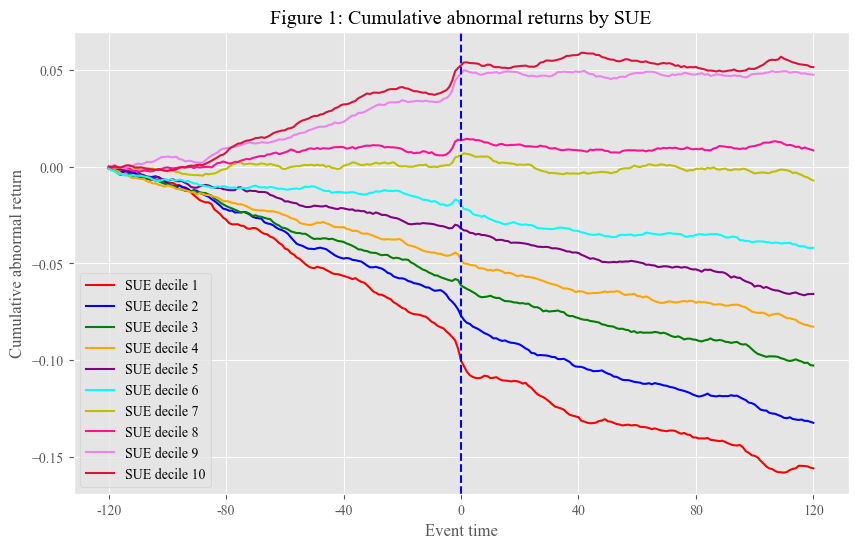

In [27]:
# 设置图形大小
plt.figure(figsize=(10, 6))
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'Times New Roman'

colors = ["red", "blue" , "green", "orange", "purple", 'cyan', 'y', 'deeppink', 'violet', 'crimson']
ncolor = 0
# 为每个SUE decile绘制时间序列图
for decile in mean_CAR_by_decile.columns[1:]:
    plt.plot(mean_CAR_by_decile['indicator'], mean_CAR_by_decile[decile], label=f'SUE decile {decile}', color = colors[ncolor])
    ncolor += 1

# 设置x轴刻度
xticks = [-120, -80, -40, 0, 40, 80, 120]
plt.xticks(xticks, xticks)

# 在横轴0处添加一条红色虚线
plt.axvline(x=0, color='blue', linestyle='--')

# 添加图例、标题和轴标签
plt.legend()
plt.title('Figure 1: Cumulative abnormal returns by SUE')
plt.xlabel('Event time')
plt.ylabel('Cumulative abnormal return')

# 显示图形
plt.show()

In [29]:
# 复制第一列 indicator
normalized_CAR = mean_CAR_by_decile.iloc[:, 0:1].copy()

# 计算第121行的数据
row_121 = mean_CAR_by_decile.iloc[121]

# 归一化处理：将所有数据+1后除以indicator=0处的数据得到归一化的累计超额收益
for i in range(1, 11):
    normalized_CAR[i] = (1 + mean_CAR_by_decile[i]).div(1 + row_121[i])

# 显示归一化后的 CAR 数据
print(normalized_CAR)

     indicator         1         2         3         4         5         6  \
0         -120  1.114867  1.085324  1.065535  1.052749  1.033284  1.021418   
1         -119  1.115413  1.084901  1.065426  1.051991  1.033625  1.020407   
2         -118  1.115088  1.084111  1.064095  1.051566  1.033221  1.020091   
3         -117  1.114463  1.083730  1.062993  1.050489  1.032835  1.018855   
4         -116  1.113944  1.083184  1.061880  1.049359  1.032484  1.018417   
..         ...       ...       ...       ...       ...       ...       ...   
236        116  0.942553  0.944028  0.958949  0.967356  0.965598  0.980297   
237        117  0.942441  0.943314  0.958138  0.966649  0.965275  0.980229   
238        118  0.942252  0.943281  0.958296  0.966385  0.965822  0.979516   
239        119  0.941519  0.942721  0.956966  0.965768  0.965935  0.979316   
240        120  0.941134  0.942213  0.956752  0.965543  0.965965  0.979524   

            7         8         9        10  
0    0.992978  0.

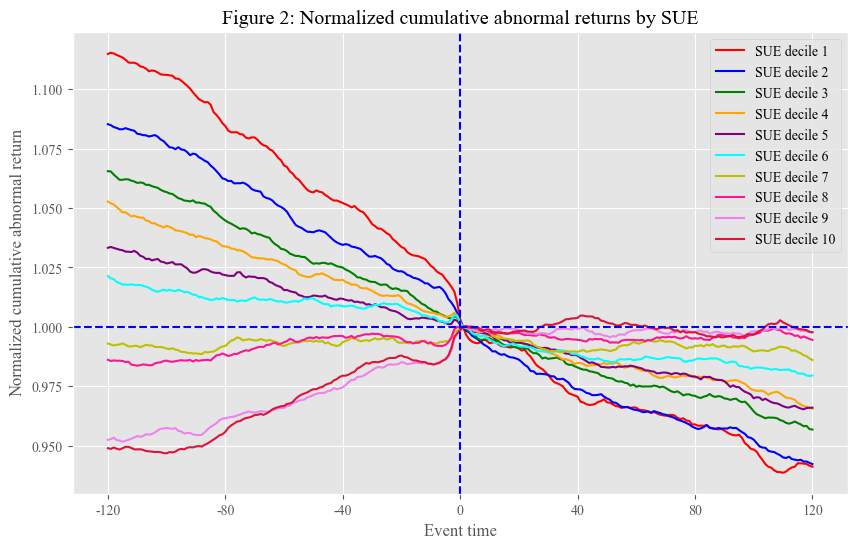

In [30]:
# 绘制归一化图像
# 设置图形大小
plt.figure(figsize=(10, 6))
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'Times New Roman'

colors = ["red", "blue" , "green", "orange", "purple", 'cyan', 'y', 'deeppink', 'violet', 'crimson']
ncolor = 0
# 为每个SUE decile绘制时间序列图
for decile in normalized_CAR.columns[1:]:
    plt.plot(normalized_CAR['indicator'], normalized_CAR[decile], label=f'SUE decile {decile}', color = colors[ncolor])
    ncolor += 1

# 设置x轴刻度
xticks = [-120, -80, -40, 0, 40, 80, 120]
plt.xticks(xticks, xticks)

# 在横轴0处添加一条红色虚线
plt.axvline(x=0, color='blue', linestyle='--')
plt.axhline(y=1, color='blue', linestyle='--')

# 添加图例和轴标签
plt.legend()
plt.title('Figure 2: Normalized cumulative abnormal returns by SUE')
plt.xlabel('Event time')
plt.ylabel('Normalized cumulative abnormal return')

# 显示图形
plt.show()